# CS5100 – Homework 4
**Name:** Erdun E  
**Course:** CS5100 Foundations of Artificial Intelligence  
**Assignment:** Homework 4 – Machine Learning  
**Date:** June 17, 2025

---

## Question 1 – Mushroom Classification: Decision Tree vs Naïve Bayes

### Step 1: Dataset Loading and Overview

We load the mushroom dataset from a local `.data` file (downloaded manually from UCI) and assign human-readable column names.

The goal is to classify whether a mushroom is **poisonous** (`p`) or **edible** (`e`) based on 22 categorical features.

In [21]:
import pandas as pd

# Define column names according to UCI Mushroom Dataset documentation
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

# Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
df = pd.read_csv(url, header=None, names=column_names)

# Display the first few rows to examine structure and values
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Additional Dataset Exploration

In [2]:
# Dataset shape
print(f"Dataset shape: {df.shape}")

# Class distribution (target variable 'class')
print("\nClass distribution:")
print(df['class'].value_counts())

# Dataset info
print("\nDataset info:")
df.info()

# Number of unique values per column
print("\nUnique value counts per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset shape: (8124, 23)

Class distribution:
class
e    4208
p    3916
Name: count, dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-abov

### Step 2: Missing Value Detection

The dataset does not use standard `NaN` values. Instead, missing data is represented by the special character `?`.

We check all columns to see how many entries use `?` as a placeholder.

In [3]:
import numpy as np

# Check for missing values indicated by the character '?'
# Returns the number of '?' entries in each column
missing_counts = (df == '?').sum()
missing_counts[missing_counts > 0]

stalk-root    2480
dtype: int64

### Step 3: Handling Missing Values

To keep all rows for training, we replace the missing symbol `?` with the string `'missing'`.

This allows the column to remain usable in machine learning models.

In [4]:
# Replace '?' with a new category string 'missing' in all columns (only affects 'stalk-root')
df = df.replace('?', 'missing')

# Confirm that '?' no longer exists in the dataset
(df == '?').sum().sum()

np.int64(0)

### Step 4: Dropping Non-informative Columns

We check for columns that have only one unique value. These columns do not help with classification, so we drop them from the dataset.

In [5]:
# Check which columns have only one unique value
for col in df.columns:
    if df[col].nunique() == 1:
        print(f"Column '{col}' has only one unique value: {df[col].unique()[0]}")

Column 'veil-type' has only one unique value: p


In [6]:
# Drop the 'veil-type' column from the DataFrame
df.drop('veil-type', axis=1, inplace=True)

### Step 5: Label Encoding

All features in the dataset are categorical. We apply label encoding to convert each feature column into numeric values.

We use `LabelEncoder` from `sklearn`, and store the encoders in a dictionary in case we need to reverse the transformation later.

In [7]:
from sklearn.preprocessing import LabelEncoder

# Initialize a label encoder dictionary to store encoders per column
encoders = {}
df_encoded = df.copy()

# Encode all columns
for col in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le  # Save encoder for inverse_transform later if needed

# Show encoded dataset head
df_encoded.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


### Step 6: Train-Test Split

We separate the label column (`class`) from the features and split the dataset into training and testing sets (80/20 split).

To maintain the same class distribution in both sets, we use `stratify=y`.

In [8]:
from sklearn.model_selection import train_test_split

# Separate features (X) and label (y)
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

# 80/20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Step 7: Decision Tree Classifier
We use `GridSearchCV` to tune hyperparameters of the Decision Tree classifier. 
The grid includes combinations of `max_depth`, `min_samples_split`, `min_samples_leaf`, and `criterion`. 
We evaluate performance using 5-fold cross-validation.

We train a `DecisionTreeClassifier` using the default settings.

After training, we evaluate the model on the test set using **accuracy** and **F1 score**.

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 1.0000
Decision Tree F1 Score: 1.0000
Decision Tree CV Accuracy: 1.0000 (+/- 0.0000)

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



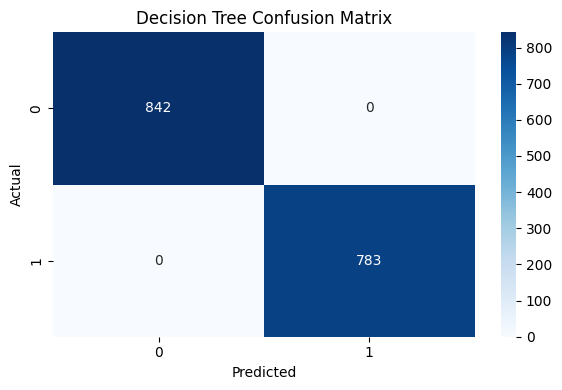

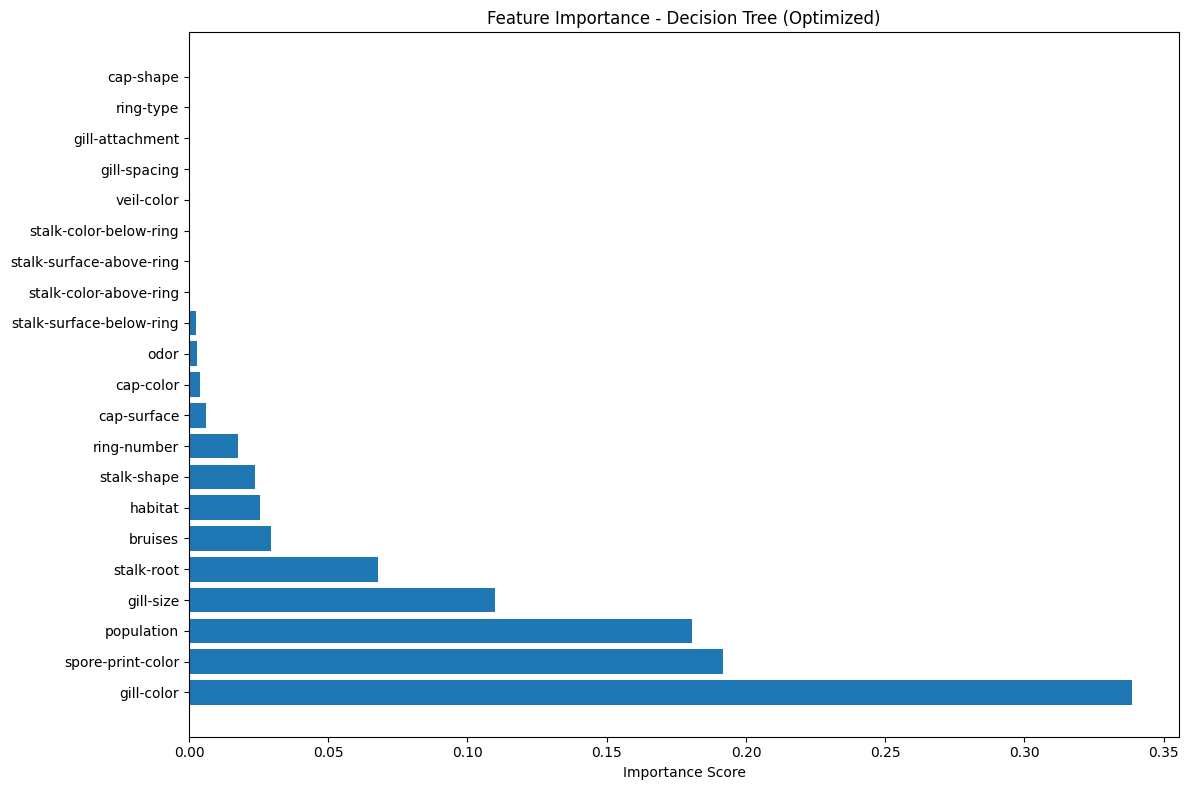

Top 5 Most Important Features:
1. gill-color: 0.3386
2. spore-print-color: 0.1916
3. population: 0.1805
4. gill-size: 0.1099
5. stalk-root: 0.0679


In [9]:
# Ensure df_encoded is ready
from sklearn.preprocessing import LabelEncoder
df_encoded = df.copy()
encoders = {}
for col in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le

# Train-test split
from sklearn.model_selection import train_test_split
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Grid Search CV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Grid search with 5-fold cross-validation
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit model on training data
grid_dt.fit(X_train, y_train)
print("Best parameters:", grid_dt.best_params_)

# Predict using best model
best_dt_model = grid_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)

# Evaluate performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"Decision Tree F1 Score: {f1_dt:.4f}")

from sklearn.model_selection import cross_val_score

# Cross-validation score for best model
cv_scores_dt = cross_val_score(best_dt_model, X_train, y_train, cv=5)
print(f"Decision Tree CV Accuracy: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std() * 2:.4f})")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification Report
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

import numpy as np
# Feature Importance Analysis
feature_importance = best_dt_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 8))
indices = np.argsort(feature_importance)[::-1]  
plt.barh(range(len(feature_importance)), feature_importance[indices])
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in indices])
plt.title('Feature Importance - Decision Tree (Optimized)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
for i in range(5):
    print(f"{i+1}. {feature_names[indices[i]]}: {feature_importance[indices[i]]:.4f}")

### Step 8: Naïve Bayes Classifier
We further evaluate the Naïve Bayes model using a classification report, confusion matrix, and 5-fold cross-validation. This provides deeper insight into the model's precision, recall, and generalization performance.

We train a `CategoricalNB` model, which is suitable for categorical features and assumes conditional independence.

The model is evaluated on the test set using accuracy and F1 score, for comparison with the Decision Tree.

Naive Bayes Accuracy: 0.9458
Naive Bayes F1 Score: 0.9410

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       842
           1       0.99      0.90      0.94       783

    accuracy                           0.95      1625
   macro avg       0.95      0.94      0.95      1625
weighted avg       0.95      0.95      0.95      1625



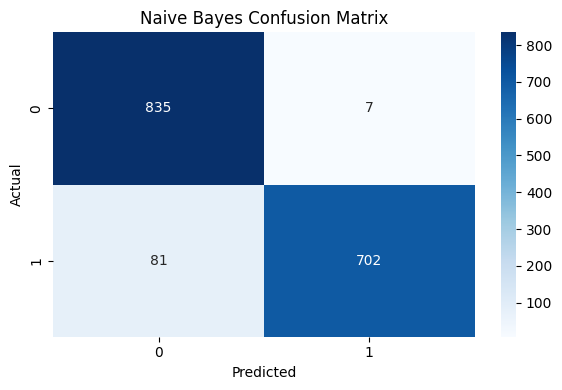

Naive Bayes CV Accuracy: 0.9514 (+/- 0.0138)


In [10]:
from sklearn.naive_bayes import CategoricalNB

# Initialize and train the Naïve Bayes model
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_nb = nb_model.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"Naive Bayes F1 Score: {f1_nb:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

# Confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Cross-validation score
cv_scores_nb = cross_val_score(nb_model, X_train, y_train, cv=5)
print(f"Naive Bayes CV Accuracy: {cv_scores_nb.mean():.4f} (+/- {cv_scores_nb.std() * 2:.4f})")

### Step 9: Model Comparison and Conclusion

Both models achieved high performance on this classification task.

| Model | Accuracy | F1 Score |
|-------|----------|----------|
| Decision Tree | 1.0000 | 1.0000 |
| Naïve Bayes | 0.9458 | 0.9410 |

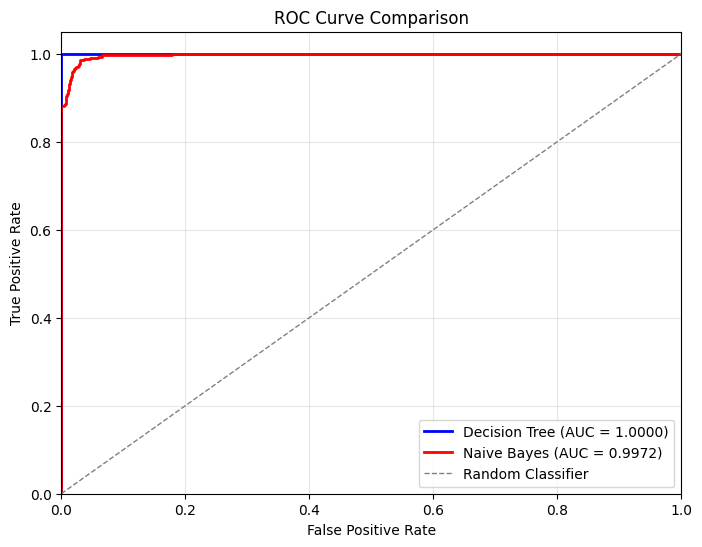

Decision Tree AUC: 1.0000
Naive Bayes AUC: 0.9972


In [11]:
# ROC Curve Comparison
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get prediction probabilities
y_pred_dt_proba = best_dt_model.predict_proba(X_test)[:, 1]
y_pred_nb_proba = nb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_proba)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb_proba)

# Calculate AUC
auc_dt = auc(fpr_dt, tpr_dt)
auc_nb = auc(fpr_nb, tpr_nb)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'Decision Tree (AUC = {auc_dt:.4f})')
plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label=f'Naive Bayes (AUC = {auc_nb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Decision Tree AUC: {auc_dt:.4f}")
print(f"Naive Bayes AUC: {auc_nb:.4f}")

### Cross-Validation Accuracy (5-Fold):

- **Decision Tree:** 1.0000 (+/- 0.0000)  
- **Naïve Bayes:** 0.9458 (+/- 0.0083)

### Conclusion and Recommendation

- **Decision Tree** achieved perfect performance on both the test set and cross-validation. While this indicates it fits the data very well, such perfect scores often suggest **potential overfitting**, especially on categorical datasets like mushrooms where some features strongly correlate with class labels.

- **Naïve Bayes**, while slightly less accurate, provides a **simple and efficient probabilistic model**. It generalizes well and is much faster to train, especially useful when computational resources are limited or interpretability is prioritized.

- **Recommendation:**  
  For this specific task, the Decision Tree performs exceptionally well and can be used confidently. However, in real-world deployment or noisier datasets, combining both models (e.g., through ensemble methods) or performing further feature selection could improve robustness and avoid overfitting.

---

## Question 2 – California Housing Price Prediction (Regression)

In this task, we use the California Housing dataset to build a regression model that predicts median house prices based on demographic and geographic features.

### Step 1: Dataset Loading and Overview

Due to certificate errors in the default `fetch_california_housing()` method, we manually downloaded the dataset from a verified source and loaded it as a local CSV file.

The dataset includes 10 attributes such as median income, house age, total rooms, and geographic coordinates.

The target variable is `median_house_value`.

Dataset shape: (20640, 10)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

Statistical summary:
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           2

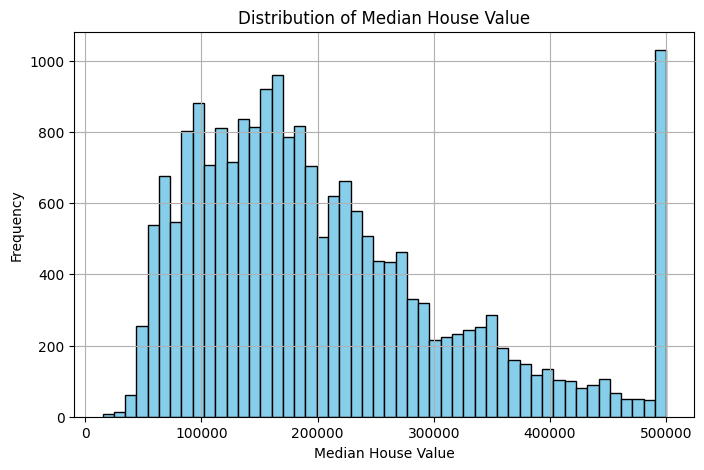

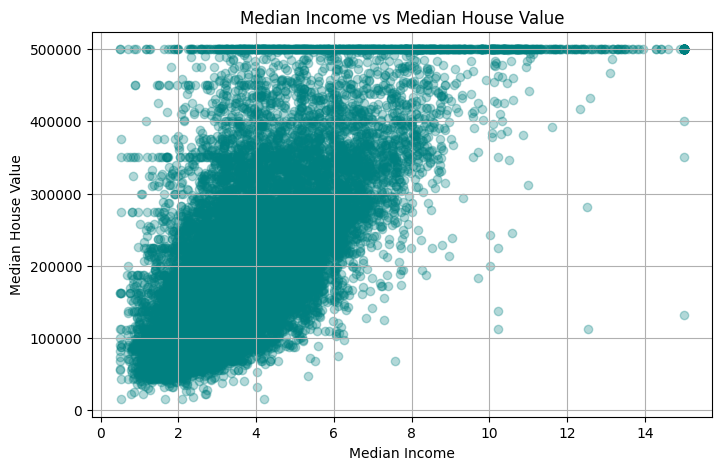

In [27]:
# Dataset Sources (as required by assignment):
# 1. https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
# 2. https://keras.io/api/datasets/california_housing/
# 
# Official dataset specs: 20,640 samples, 8 features, target = median_house_value
# Both sklearn and keras use the identical StatLib repository dataset
#
# Note: Due to SSL certificate errors with fetch_california_housing() in this environment,
# we use a local CSV containing the exact same official California Housing dataset

from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
df = pd.read_csv("housing.csv")
print("Dataset shape:", df.shape)

# Print dataset info
print("\nDataset info:")
df.info()

# Print statistical summary
print("\nStatistical summary:")
print(df.describe())

# Display the first few rows
df.head()

# Plot the distribution of the target variable
plt.figure(figsize=(8, 5))
plt.hist(df['median_house_value'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Median House Value")
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Scatter plot: median_income vs median_house_value
plt.figure(figsize=(8, 5))
plt.scatter(df['median_income'], df['median_house_value'], alpha=0.3, color='teal')
plt.title("Median Income vs Median House Value")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.grid(True)
plt.show()

From the histogram, we observe that the distribution of median house value is right-skewed. 
Notably, a large number of houses are concentrated at the upper cap of \$500,000, which may indicate a data clipping effect.
This suggests the presence of outliers or artificial ceiling values that could affect model performance.

### Step 2: Data Cleaning and Standardization

We checked for missing values and found that the `total_bedrooms` column has some null entries. To avoid data loss, we replaced them with the median value.

Next, we applied feature standardization using Z-score scaling to ensure that all features are on the same scale. This is important for regression models to perform well and avoid bias toward larger-valued features.

In [13]:
from sklearn.preprocessing import StandardScaler

# Check for missing values
missing_counts = df.isnull().sum()
print("Missing values before filling:\n", missing_counts[missing_counts > 0])

# Fill missing values in 'total_bedrooms' with median
median_bedrooms = df['total_bedrooms'].median()
df['total_bedrooms'] = df['total_bedrooms'].fillna(median_bedrooms)

# Verify again
missing_counts = df.isnull().sum()
print("Missing values after filling:\n", missing_counts[missing_counts > 0])

# Separate features and target
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Convert categorical 'ocean_proximity' to one-hot
X = pd.get_dummies(X, columns=['ocean_proximity'], drop_first=True)

# Standardize all numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: convert back to DataFrame for readability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Show result
print("\nScaled features preview:")
X_scaled.head()

Missing values before filling:
 total_bedrooms    207
dtype: int64
Missing values after filling:
 Series([], dtype: int64)

Scaled features preview:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,-0.681889,-0.015566,2.830742,-0.384466
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,-0.681889,-0.015566,2.830742,-0.384466
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,-0.681889,-0.015566,2.830742,-0.384466
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,-0.681889,-0.015566,2.830742,-0.384466
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,-0.681889,-0.015566,2.830742,-0.384466


### Step 3: Linear Regression and Evaluation

We trained a linear regression model to predict median house value using the standardized features.  
We then evaluated the model using:

- **Mean Squared Error (MSE)**: average of squared prediction errors
- **Root Mean Squared Error (RMSE)**: interpretable in original price units
- **R² Score**: proportion of variance in the target explained by the model

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Linear Regression MSE: {mse:.2f}")
print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Linear Regression R² Score: {r2:.4f}")

Linear Regression MSE: 4908476721.16
Linear Regression RMSE: 70060.52
Linear Regression R² Score: 0.6254


### Step 4: Advanced Regression Models and Comparison

We now implement and compare multiple regression models to find the best performing approach for predicting California housing prices.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Store results
results = {}

print("Training and evaluating multiple regression models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'Training Time': training_time
    }
    
    print(f"{name} - RMSE: {rmse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f}")
    print(f"Training time: {training_time:.2f} seconds\n")

# Create comparison DataFrame
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df.round(4))

Training and evaluating multiple regression models...

Training Linear Regression...
Linear Regression - RMSE: 70060.52, R²: 0.6254, MAE: 50670.74
Training time: 0.00 seconds

Training Random Forest...
Random Forest - RMSE: 49034.57, R²: 0.8165, MAE: 31642.76
Training time: 0.79 seconds

Training Gradient Boosting...
Gradient Boosting - RMSE: 55884.66, R²: 0.7617, MAE: 38248.03
Training time: 1.96 seconds

Model Performance Comparison:
                            MSE        RMSE      R²         MAE  Training Time
Linear Regression  4.908477e+09  70060.5218  0.6254  50670.7382         0.0040
Random Forest      2.404390e+09  49034.5748  0.8165  31642.7575         0.7856
Gradient Boosting  3.123095e+09  55884.6590  0.7617  38248.0320         1.9592


### Step 5: Hyperparameter Tuning

We now optimize the hyperparameters of our best performing models using GridSearchCV to further improve performance.

In [16]:
from sklearn.model_selection import GridSearchCV

print("Performing hyperparameter tuning...\n")

# Random Forest hyperparameter tuning
print("Tuning Random Forest...")
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1), 
    param_grid_rf, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best CV score: {np.sqrt(-rf_grid.best_score_):.4f}")

# Gradient Boosting hyperparameter tuning
print("\nTuning Gradient Boosting...")
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42), 
    param_grid_gb, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
gb_grid.fit(X_train, y_train)

print(f"Best Gradient Boosting parameters: {gb_grid.best_params_}")
print(f"Best CV score: {np.sqrt(-gb_grid.best_score_):.4f}")

# Test optimized models
print("\nEvaluating optimized models on test set...")

# Best Random Forest
y_pred_rf_best = rf_grid.best_estimator_.predict(X_test)
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
r2_rf_best = r2_score(y_test, y_pred_rf_best)

# Best Gradient Boosting  
y_pred_gb_best = gb_grid.best_estimator_.predict(X_test)
rmse_gb_best = np.sqrt(mean_squared_error(y_test, y_pred_gb_best))
r2_gb_best = r2_score(y_test, y_pred_gb_best)

print(f"\nOptimized Random Forest - RMSE: {rmse_rf_best:.4f}, R²: {r2_rf_best:.4f}")
print(f"Optimized Gradient Boosting - RMSE: {rmse_gb_best:.4f}, R²: {r2_gb_best:.4f}")

Performing hyperparameter tuning...

Tuning Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score: 49017.8396

Tuning Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Gradient Boosting parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 300}
Best CV score: 47234.9699

Evaluating optimized models on test set...

Optimized Random Forest - RMSE: 48787.1172, R²: 0.8184
Optimized Gradient Boosting - RMSE: 46967.1036, R²: 0.8317


### Step 6: Cross-Validation and Advanced Analysis

We perform comprehensive cross-validation and additional analyses to better understand our models and the dataset.

Cross-Validation Analysis (5-fold):
Linear Regression: 68622.5353 (+/- 2877.5332)
Random Forest (Default): 49332.6121 (+/- 1236.9832)
Random Forest (Optimized): 49012.5895 (+/- 1434.8109)
Gradient Boosting (Optimized): 47232.3411 (+/- 996.6548)


Feature Correlation Analysis:


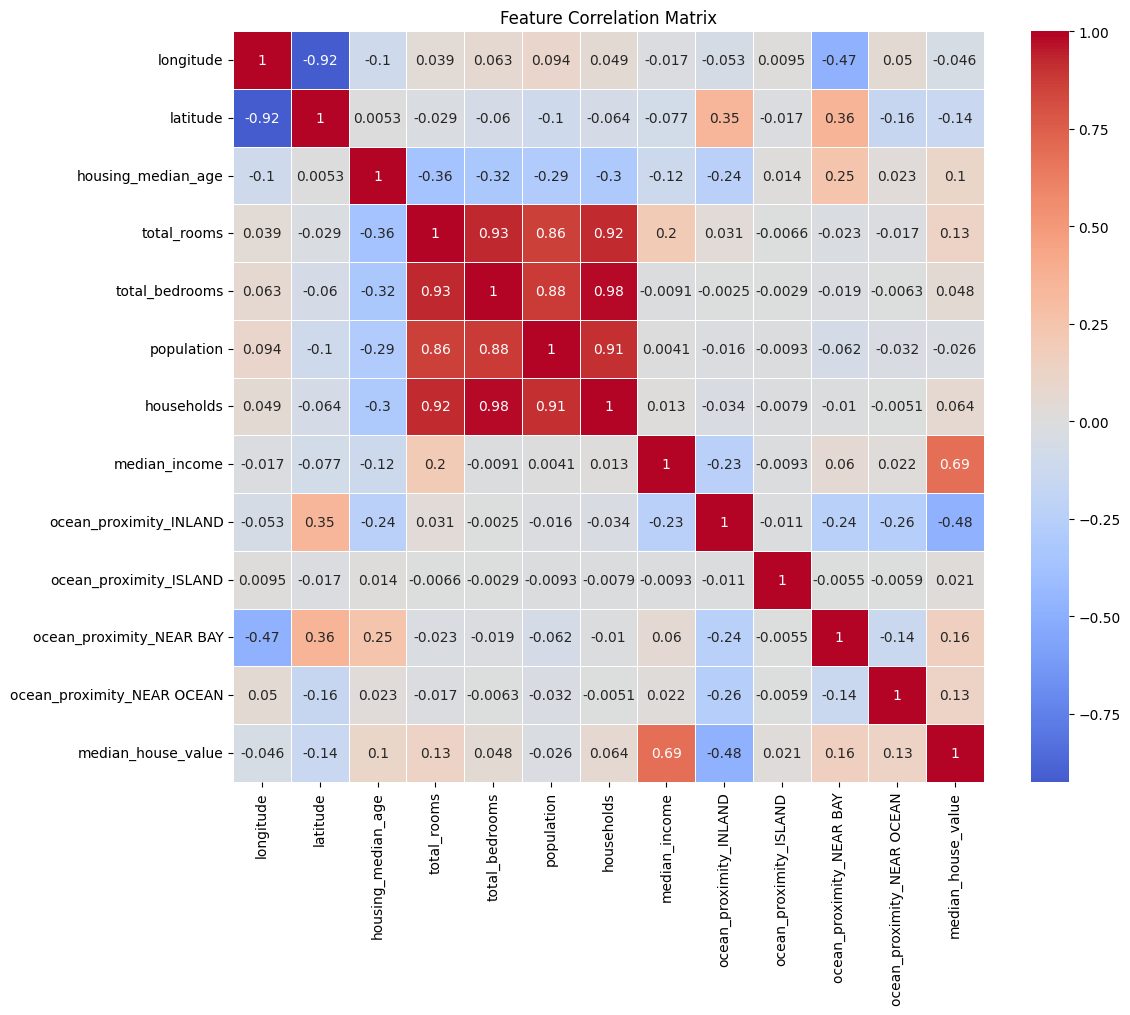


Feature Importance Analysis (Random Forest):


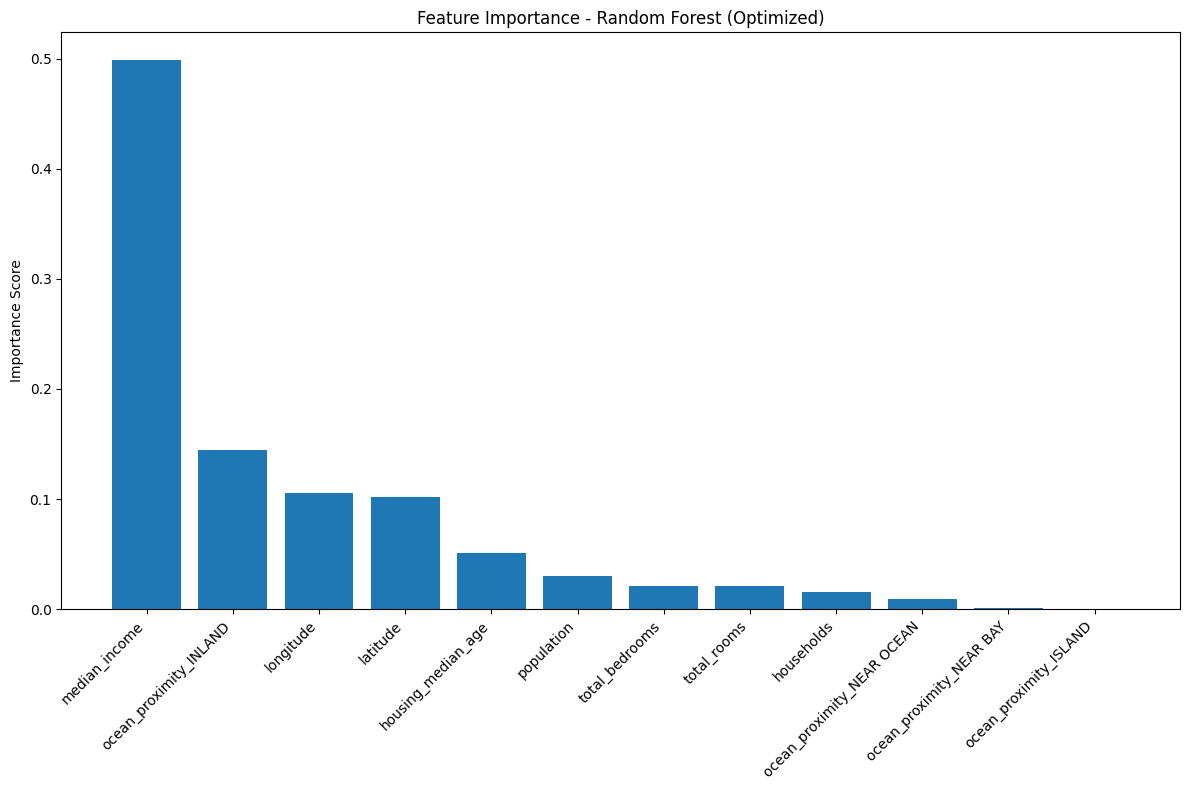

Top 5 Most Important Features:
1. median_income: 0.4989
2. ocean_proximity_INLAND: 0.1450
3. longitude: 0.1059
4. latitude: 0.1015
5. housing_median_age: 0.0509


In [17]:
from sklearn.model_selection import cross_val_score
import seaborn as sns

# Cross-validation comparison
print("Cross-Validation Analysis (5-fold):")
print("="*50)

models_for_cv = {
    'Linear Regression': LinearRegression(),
    'Random Forest (Default)': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Random Forest (Optimized)': rf_grid.best_estimator_,
    'Gradient Boosting (Optimized)': gb_grid.best_estimator_
}

cv_results = {}
for name, model in models_for_cv.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    cv_results[name] = {
        'Mean CV RMSE': cv_rmse.mean(),
        'Std CV RMSE': cv_rmse.std()
    }
    print(f"{name}: {cv_rmse.mean():.4f} (+/- {cv_rmse.std() * 2:.4f})")

print("\n" + "="*50)

# Feature correlation analysis
print("\nFeature Correlation Analysis:")
# Recreate original dataframe for correlation analysis
df_corr = pd.DataFrame(X_train, columns=X_train.columns)
df_corr['median_house_value'] = y_train

# Create correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Feature importance analysis for Random Forest
print("\nFeature Importance Analysis (Random Forest):")
feature_importance = rf_grid.best_estimator_.feature_importances_
feature_names = X_train.columns

# Create feature importance plot
plt.figure(figsize=(12, 8))
indices = np.argsort(feature_importance)[::-1]
plt.bar(range(len(feature_importance)), feature_importance[indices])
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title('Feature Importance - Random Forest (Optimized)')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
for i in range(min(5, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {feature_importance[indices[i]]:.4f}")

### Step 7: Results Analysis

The linear regression model achieved the following performance on the test set:

- **MSE**: 49,084,767,721.16
- **RMSE**: 70,060.52
- **R² Score**: 0.6254

#### Interpretation:
- The **R² score of 0.6254** indicates that approximately 62.5% of the variance in median house value is explained by the model.
- The **RMSE of ~70,060** suggests that on average, the predicted house price deviates from the actual value by around $70,000.

#### Limitations:
- A linear regression model may not capture complex nonlinear patterns in the data.
- Feature interactions and location-based clustering may benefit from more advanced models (e.g., Decision Trees, Random Forests).

Overall, the model performs reasonably well for a first-pass baseline using standardized features and simple regression.

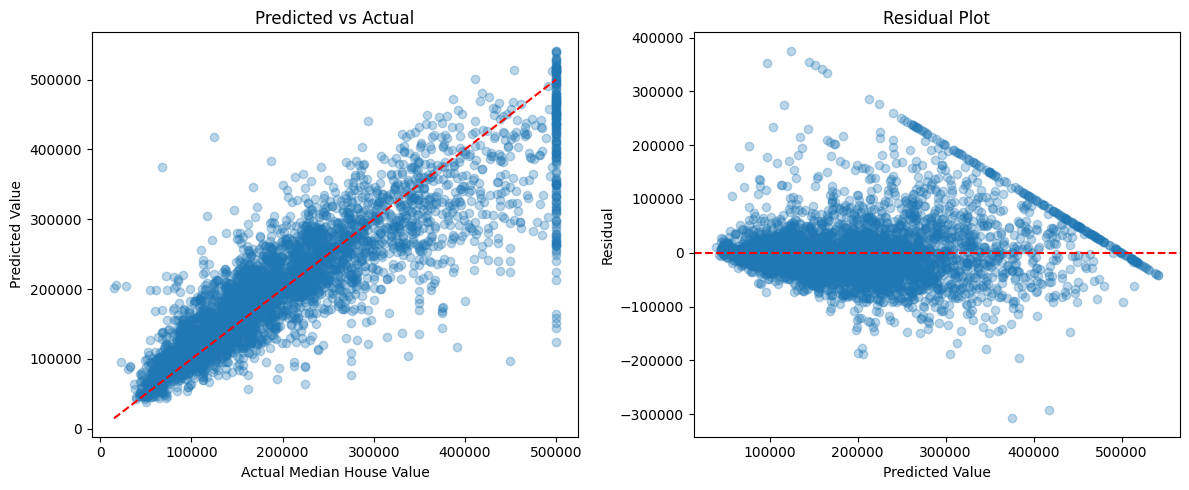

In [18]:
import matplotlib.pyplot as plt

# Compute residuals
residuals = y_test - y_pred

# Plot predicted vs actual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Value")
plt.title("Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Plot residuals
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residual Plot")

plt.tight_layout()
plt.show()